# Preprocessing screening data

This notebook describes and performs the calculations used to "preprocess" all base editor data, starting from raw read counts (from the supplementary data) and ending with LFC values and z-scores. The following steps are performed for each screen:

1. Calculate lognorms and log-fold-change (from pDNA and from dropout / no drug condition)
2. Merge with annotations file
3. Filter out any sgRNAs for which the lognorm of pDNA is > 3 SD from the mean
4. Filter out any sgRNAs with > 5 Match Bin I off-targets
5. Return a filtered file for use in all downstream calculations
6. Generate the boxplot of distributions of negative and positive control sgRNAs

In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import base_edit_functions as be
import warnings

warnings.filterwarnings('ignore')

In [3]:
import sys
print('Python version: ' + sys.version)
modules = ['pandas', 'seaborn', 'matplotlib', 'numpy', 're', 'scipy']
for module in modules:
    try:
        print(module + ' ' + sys.modules[module].__version__)
    except:
        print(module + ' has no __version__ attribute')

Python version: 2.7.15 | packaged by conda-forge | (default, Mar  5 2020, 14:58:04) 
[GCC Clang 9.0.1 ]
pandas 0.24.2
seaborn 0.9.0
matplotlib 2.2.5
numpy 1.16.5
re 2.2.1
scipy 1.2.1


In [4]:
def get_lfc_files(filename,sheet):
    supp_table = be.get_colnames_from_supp_table('../Data/Supplementary_Tables/'+filename, sheet)
    supp_table = be.calc_lognorm(supp_table)
    supp_table = be.calc_lfc_from_pdna(supp_table)
    return supp_table

In [5]:
def process_data(filename,sheet,annot_sheet,conditions_list=[],tiling=True):
    
    # Read in data from sheet
    # Calculate lognorms
    # Calculate LFC from pDNA
    data = get_lfc_files(filename,sheet)

    # Get LFC from dropout (untreated) for specified columns
    for val in conditions_list:
        data = be.get_lfc_dropout(cell_line=val[0],condition=val[1],reps=val[2],df=data)
    # Add annotations
    annot = pd.read_excel('../Data/Supplementary_Tables/'+filename, sheet_name=annot_sheet)
    data = pd.merge(data,annot,left_on='Construct Barcode', right_on='sgRNA sequence',how='inner')

    # pDNA filter
    data = be.filter_pDNA_v2(data)
    
    # Off-target filter
    data.loc[:,'Off_target_filter'] = data.loc[:,'Match Bin I counts'].apply(be.filter_off_targets_v2)
    
    # Apply both filters
    filtered = data.loc[(data['pDNA_filter'] == True) & (data['Off_target_filter'] == True), :]
    
    if tiling:
        filtered.loc[:,'Mutation bin'] = filtered['Mutation category'].apply(be.GetMostSevereMutationType)
        filtered.loc[:,'Clinical significance bin'] = filtered['Clinical significance'].apply(be.GetMostSevereClinSig)
        filtered.loc[:,'Residues'] = filtered['Amino acid edits'].apply(be.GetResidues)
        filtered.loc[:,'Median Residues'] = filtered.apply(be.GetMedianResidues_v2,axis=1)
    
    return filtered

In [6]:
def generate_qc_boxplot(df,col,ctrls,x_col,outputname):
    color_array = ['#66c2a5']
    color_array.extend(['#fc8d62']*(len(ctrls)-1))
    flierprops = dict(markersize=3, 
                      marker='o',
                      linestyle='none', 
                      markerfacecolor='black',
                      markeredgecolor='black')
    fig, ax = plt.subplots()
    g = sns.boxplot(x=x_col, 
                    y=col,
                    order = ctrls,
                    data=df, 
                    width=0.7,
                    flierprops=flierprops)
    for i in range(0,len(ctrls)):
        mybox = g.artists[i]
        mybox.set_facecolor(color_array[i])
        mybox.set_edgecolor('black')
    
    sns.despine()
    t = plt.xticks(rotation=70, fontsize=12)
    t = plt.yticks(fontsize=12)
    t = plt.ylabel('Log2-fold change', fontsize=14)
    t = plt.xlabel('')
    t = plt.title(col)
    plt.setp(g.lines, color='black')
    plt.savefig('../Figures/QC_plots/'+outputname+'.pdf', dpi=1000)
    return 

### Table S1 (pan-lethal tiling library)

In [20]:
filtered = process_data(filename='Supplementary_Table1_TilingData_v9.xlsx',sheet='BE3.9max',
                        conditions_list=[['A375','Vemurafenib',['A','B']]],annot_sheet='Library annotation')

# Merge replicates
cols = []
for cell_line in ['A375','HAP1','HA1E','OVCAR8','MELJUSO']:
    filtered.loc[:,cell_line+';Dropout;AvgAB;LFC_pdna'] = filtered.loc[:,[cell_line+';Dropout;RepA;LFC_pdna',
                                                                          cell_line+';Dropout;RepB;LFC_pdna']].mean(axis=1)
    cols.append(cell_line+';Dropout;AvgAB;LFC_pdna')
filtered.loc[:,'A375;Vemurafenib;MinAB;LFC_dropout'] = filtered.loc[:,['A375;Vemurafenib;RepA;LFC_dropout',
                                                                       'A375;Vemurafenib;RepB;LFC_dropout']].min(axis=1)
cols.append('A375;Vemurafenib;MinAB;LFC_dropout')

# Get z-scored LFC relative to specified control genes
for col in cols:
    filtered = be.get_z_score_v3(filtered,col,'Gene symbol',['ICAM1','CD33','CD81','FAS'])

# Write to file
filtered.to_csv('../Data/Filtered_LFC_files/Table_S1_filtered_BE3_v1.csv',index=False)


In [21]:
filtered = process_data(filename='Supplementary_Table1_TilingData_v9.xlsx',sheet='BE4max',
                        conditions_list=[['A375','Vemurafenib',['A','B']]],annot_sheet='Library annotation')

# Merge replicates
filtered.loc[:,'A375;Dropout;AvgAB;LFC_pdna'] = filtered.loc[:,['A375;Dropout;RepA;LFC_pdna',
                                                                'A375;Dropout;RepB;LFC_pdna']].mean(axis=1)
filtered.loc[:,'A375;Vemurafenib;MinAB;LFC_dropout'] = filtered.loc[:,['A375;Vemurafenib;RepA;LFC_dropout',
                                                                       'A375;Vemurafenib;RepB;LFC_dropout']].min(axis=1)
cols = ['A375;Dropout;AvgAB;LFC_pdna','A375;Vemurafenib;MinAB;LFC_dropout']

# Get z-scored LFC relative to specified control genes
for col in cols:
    filtered = be.get_z_score_v3(filtered,col,'Gene symbol',['ICAM1','CD33','CD81','FAS'])

# Write to file
filtered.to_csv('../Data/Filtered_LFC_files/Table_S1_filtered_BE4_v1.csv',index=False)    
    

In [22]:
filtered = process_data(filename='Supplementary_Table1_TilingData_v9.xlsx',sheet='wtCas9',
                        conditions_list=[['A375','Vemurafenib',['A','B']]],annot_sheet='Library annotation')

# Merge replicates
cols = []
for cell_line in ['A375','MELJUSO']:
    filtered.loc[:,cell_line+';Dropout;AvgAB;LFC_pdna'] = filtered.loc[:,[cell_line+';Dropout;RepA;LFC_pdna',
                                                                          cell_line+';Dropout;RepB;LFC_pdna']].mean(axis=1)
    cols.append(cell_line+';Dropout;AvgAB;LFC_pdna')
filtered.loc[:,'A375;Vemurafenib;MinAB;LFC_dropout'] = filtered.loc[:,['A375;Vemurafenib;RepA;LFC_dropout',
                                                                       'A375;Vemurafenib;RepB;LFC_dropout']].min(axis=1)
cols.append('A375;Vemurafenib;MinAB;LFC_dropout')

# Get z-scored LFC relative to specified control genes
for col in cols:
    filtered = be.get_z_score_v3(filtered,col,'Gene symbol',['ICAM1','CD33','CD81','FAS'])

# Write to file
filtered.to_csv('../Data/Filtered_LFC_files/Table_S1_filtered_WT-Cas9_v1.csv',index=False)    
    

### Table S2 (BRCA1 and BRCA2 tiling screens)

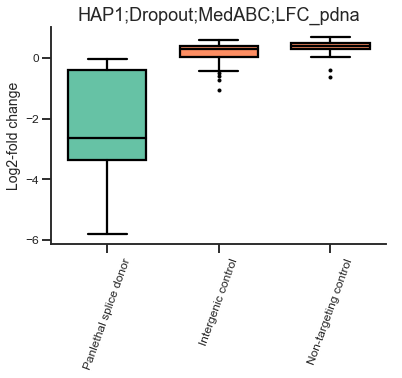

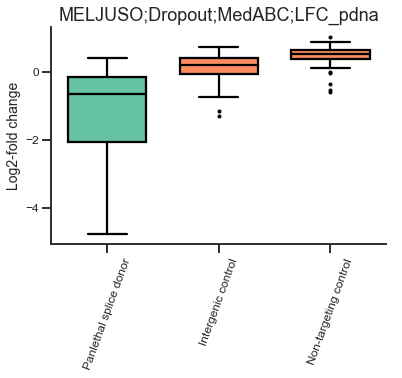

In [23]:
# BRCA1

filtered = process_data(filename='Supplementary_Table3_BRCA_Tiling_v6.xlsx',sheet='BRCA1',annot_sheet='BRCA1 Library annotation')

# Merge replicates
filtered.loc[:,'HAP1;Dropout;MedABC;LFC_pdna'] = filtered.loc[:,['HAP1;Dropout;RepA;LFC_pdna',
                                                                 'HAP1;Dropout;RepB;LFC_pdna',
                                                                 'HAP1;Dropout;RepC;LFC_pdna']].median(axis=1)
filtered.loc[:,'MELJUSO;Dropout;MedABC;LFC_pdna'] = filtered.loc[:,['MELJUSO;Dropout;RepA;LFC_pdna',
                                                                 'MELJUSO;Dropout;RepB;LFC_pdna',
                                                                 'MELJUSO;Dropout;RepC;LFC_pdna']].median(axis=1)
filtered.loc[:,'MELJUSO;Talazoparib;MedABC;LFC_pdna'] = filtered.loc[:,['MELJUSO;Talazoparib;RepA;LFC_pdna',
                                                                        'MELJUSO;Talazoparib;RepB;LFC_pdna',
                                                                        'MELJUSO;Talazoparib;RepC;LFC_pdna']].median(axis=1)
filtered.loc[:,'MELJUSO;Cisplatin;MedABC;LFC_pdna'] = filtered.loc[:,['MELJUSO;Cisplatin;RepA;LFC_pdna',
                                                                      'MELJUSO;Cisplatin;RepB;LFC_pdna',
                                                                      'MELJUSO;Cisplatin;RepC;LFC_pdna']].median(axis=1)
filtered.loc[:,'MELJUSO;AvgTalazoparib_Cisplatin;LFC_pdna'] = filtered.loc[:,['MELJUSO;Talazoparib;MedABC;LFC_pdna',
                                                                              'MELJUSO;Cisplatin;MedABC;LFC_pdna']].mean(axis=1)
# Average together the 2 cell lines
filtered.loc[:,'AvgHAP1_MELJUSO;LFC_pdna'] = filtered.loc[:,['MELJUSO;AvgTalazoparib_Cisplatin;LFC_pdna',
                                                             'HAP1;Dropout;MedABC;LFC_pdna']].mean(axis=1)

# Get z-scored LFC relative to specified control genes
filtered = be.get_z_score_v3(filtered,'AvgHAP1_MELJUSO;LFC_pdna','Gene symbol',['Intergenic control'])

# Write to file
filtered.to_csv('../Data/Filtered_LFC_files/Table_S2_filtered_BRCA1_v1.csv',index=False)    

# Generate boxplots to show distribution of negative and positive control sgRNAs
dropout_cols = [x for x in list(filtered.columns) if ('Dropout' in x)&('MedABC' in x)&('z-score' not in x)]
ctrls = ['Panlethal splice donor','Intergenic control','Non-targeting control']
ctrl_df = filtered[filtered['Gene symbol'].isin(ctrls)]
for i,c in enumerate(dropout_cols):
    outputname = c+'_controls_boxplot' 
    generate_qc_boxplot(ctrl_df,c,ctrls,'Gene symbol',outputname)
    

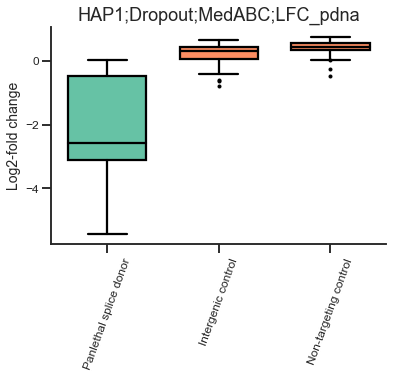

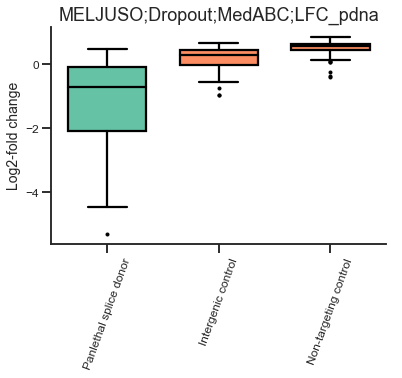

In [24]:
# BRCA2

filtered = process_data(filename='Supplementary_Table3_BRCA_Tiling_v6.xlsx',sheet='BRCA2',annot_sheet='BRCA2 Library annotation')

# Merge replicates
filtered.loc[:,'HAP1;Dropout;MedABC;LFC_pdna'] = filtered.loc[:,['HAP1;Dropout;RepA;LFC_pdna',
                                                                 'HAP1;Dropout;RepB;LFC_pdna',
                                                                 'HAP1;Dropout;RepC;LFC_pdna']].median(axis=1)
filtered.loc[:,'MELJUSO;Dropout;MedABC;LFC_pdna'] = filtered.loc[:,['MELJUSO;Dropout;RepA;LFC_pdna',
                                                                 'MELJUSO;Dropout;RepB;LFC_pdna',
                                                                 'MELJUSO;Dropout;RepC;LFC_pdna']].median(axis=1)
filtered.loc[:,'MELJUSO;Talazoparib;MedABC;LFC_pdna'] = filtered.loc[:,['MELJUSO;Talazoparib;RepA;LFC_pdna',
                                                                        'MELJUSO;Talazoparib;RepB;LFC_pdna',
                                                                        'MELJUSO;Talazoparib;RepC;LFC_pdna']].median(axis=1)
filtered.loc[:,'MELJUSO;Cisplatin;MedABC;LFC_pdna'] = filtered.loc[:,['MELJUSO;Cisplatin;RepA;LFC_pdna',
                                                                      'MELJUSO;Cisplatin;RepB;LFC_pdna',
                                                                      'MELJUSO;Cisplatin;RepC;LFC_pdna']].median(axis=1)
filtered.loc[:,'MELJUSO;AvgTalazoparib_Cisplatin;LFC_pdna'] = filtered.loc[:,['MELJUSO;Talazoparib;MedABC;LFC_pdna',
                                                                              'MELJUSO;Cisplatin;MedABC;LFC_pdna']].mean(axis=1)
# Average together the 2 cell lines
filtered.loc[:,'AvgHAP1_MELJUSO;LFC_pdna'] = filtered.loc[:,['MELJUSO;AvgTalazoparib_Cisplatin;LFC_pdna',
                                                             'HAP1;Dropout;MedABC;LFC_pdna']].mean(axis=1)

# Get z-scored LFC relative to specified control genes
filtered = be.get_z_score_v3(filtered,'AvgHAP1_MELJUSO;LFC_pdna','Gene symbol',['Intergenic control'])

# Write to file
filtered.to_csv('../Data/Filtered_LFC_files/Table_S2_filtered_BRCA2_v1.csv',index=False)    
    
# Generate boxplots to show distribution of negative and positive control sgRNAs
dropout_cols = [x for x in list(filtered.columns) if ('Dropout' in x)&('MedABC' in x)&('z-score' not in x)]
ctrls = ['Panlethal splice donor','Intergenic control','Non-targeting control']
ctrl_df = filtered[filtered['Gene symbol'].isin(ctrls)]
for i,c in enumerate(dropout_cols):
    outputname = c+'_controls_boxplot' 
    generate_qc_boxplot(ctrl_df,c,ctrls,'Gene symbol',outputname)
    

### Table S4 (MCL1)

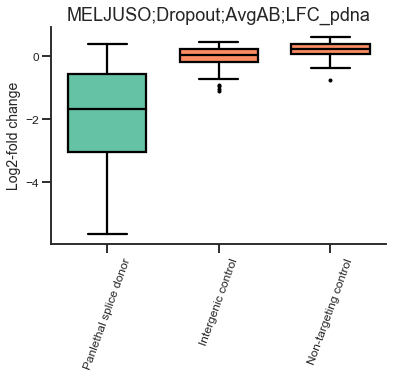

In [25]:
filtered = process_data(filename='Supplementary_Table6_MCL1_Tiling_v4.xlsx',sheet='MCL1',
                        conditions_list=[['MELJUSO','A1331852',['A','B']],['MELJUSO','A1331852+S63845',['A','B']]],
                        annot_sheet='Library annotation')

# Merge replicates
filtered.loc[:,'MELJUSO;Dropout;AvgAB;LFC_pdna'] = filtered.loc[:,['MELJUSO;Dropout;RepA;LFC_pdna','MELJUSO;Dropout;RepB;LFC_pdna']].mean(axis=1)
filtered.loc[:,'MELJUSO;A1331852;AvgAB;LFC_dropout'] = filtered.loc[:,['MELJUSO;A1331852;RepA;LFC_dropout',
                                                                       'MELJUSO;A1331852;RepB;LFC_dropout']].mean(axis=1)
filtered.loc[:,'MELJUSO;A1331852+S63845;AvgAB;LFC_dropout'] = filtered.loc[:,['MELJUSO;A1331852+S63845;RepA;LFC_dropout',
                                                                              'MELJUSO;A1331852+S63845;RepB;LFC_dropout']].mean(axis=1)                                                                 

# Get z-scored LFC relative to specified control genes
cols = ['MELJUSO;Dropout;AvgAB;LFC_pdna','MELJUSO;A1331852;AvgAB;LFC_dropout','MELJUSO;A1331852+S63845;AvgAB;LFC_dropout'] 
for col in cols:                                                                           
    filtered = be.get_z_score_v3(filtered,col,'Gene symbol',['Intergenic control'])

# Write to file
filtered.to_csv('../Data/Filtered_LFC_files/Table_S4_filtered_MCL1_v1.csv',index=False)    

# Generate boxplots to show distribution of negative and positive control sgRNAs
dropout_cols = [x for x in list(filtered.columns) if ('Dropout' in x)&('AvgAB' in x)&('z-score' not in x)]
ctrls = ['Panlethal splice donor','Intergenic control','Non-targeting control']
ctrl_df = filtered[filtered['Gene symbol'].isin(ctrls)]
for i,c in enumerate(dropout_cols):
    outputname = c+'_controls_boxplot' 
    generate_qc_boxplot(ctrl_df,c,ctrls,'Gene symbol',outputname)
    

### Table S5 (BCL2L1)

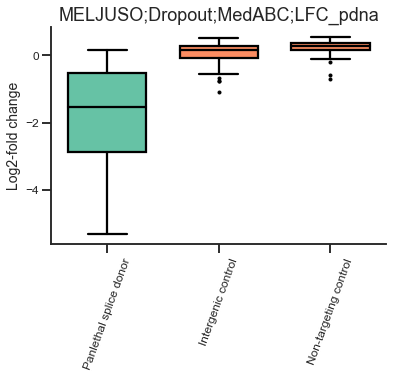

In [26]:
filtered = process_data(filename='Supplementary_Table7_BCL2L1_Tiling_v5.xlsx',sheet='BCL2L1',
                        conditions_list=[['MELJUSO','S63845',['A','B','C']],['MELJUSO','A1331852+S63845',['A','B','C']]],
                        annot_sheet='Library annotation')

# Merge replicates
filtered.loc[:,'MELJUSO;Dropout;MedABC;LFC_pdna'] = filtered.loc[:,['MELJUSO;Dropout;RepA;LFC_pdna',
                                                                    'MELJUSO;Dropout;RepB;LFC_pdna',
                                                                    'MELJUSO;Dropout;RepC;LFC_pdna']].median(axis=1)
filtered.loc[:,'MELJUSO;S63845;MedABC;LFC_dropout'] = filtered.loc[:,['MELJUSO;S63845;RepA;LFC_dropout',
                                                                      'MELJUSO;S63845;RepB;LFC_dropout',
                                                                      'MELJUSO;S63845;RepC;LFC_dropout']].median(axis=1)
filtered.loc[:,'MELJUSO;A1331852+S63845;MedABC;LFC_dropout'] = filtered.loc[:,['MELJUSO;A1331852+S63845;RepA;LFC_dropout',
                                                                               'MELJUSO;A1331852+S63845;RepB;LFC_dropout',
                                                                               'MELJUSO;A1331852+S63845;RepC;LFC_dropout']].median(axis=1)                                                                 

# Get z-scored LFC relative to specified control genes
cols = ['MELJUSO;Dropout;MedABC;LFC_pdna','MELJUSO;S63845;MedABC;LFC_dropout','MELJUSO;A1331852+S63845;MedABC;LFC_dropout'] 
for col in cols:                                                                           
    filtered = be.get_z_score_v3(filtered,col,'Gene symbol',['Intergenic control'])

# Write to file
filtered.to_csv('../Data/Filtered_LFC_files/Table_S5_filtered_BCL2L1_v1.csv',index=False)    

# Generate boxplots to show distribution of negative and positive control sgRNAs
dropout_cols = [x for x in list(filtered.columns) if ('Dropout' in x)&('MedABC' in x)&('z-score' not in x)]
ctrls = ['Panlethal splice donor','Intergenic control','Non-targeting control']
ctrl_df = filtered[filtered['Gene symbol'].isin(ctrls)]
for i,c in enumerate(dropout_cols):
    outputname = c+'_controls_boxplot' 
    generate_qc_boxplot(ctrl_df,c,ctrls,'Gene symbol',outputname)

### Table S6 (PARP1)

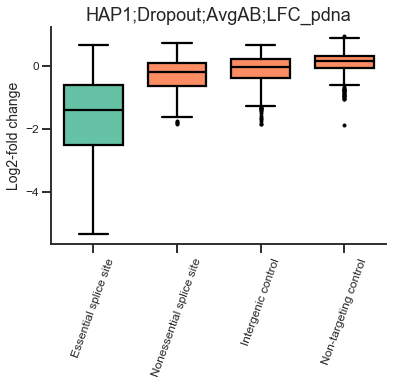

In [27]:
filtered = process_data(filename='Supplementary_Table9_DrugTargetTiling_v5.xlsx',sheet='BE3_HAP1',
                        conditions_list=[['HAP1','Niraparib',['A','B']],
                                         ['HAP1','Olaparib',['A','B']],
                                         ['HAP1','Rucaparib',['A','B']],
                                         ['HAP1','Talazoparib',['A','B']],
                                         ['HAP1','Veliparib',['A','B']],],
                        annot_sheet='Library annotation')

# Merge replicates
filtered.loc[:,'HAP1;Dropout;AvgAB;LFC_pdna'] = filtered.loc[:,['HAP1;Dropout;RepA;LFC_pdna','HAP1;Dropout;RepB;LFC_pdna']].mean(axis=1)
cols = ['HAP1;Dropout;AvgAB;LFC_pdna']
for drug in ['Niraparib','Olaparib','Rucaparib','Talazoparib','Veliparib']:
    filtered.loc[:,'HAP1;'+drug+';AvgAB;LFC_dropout'] = filtered.loc[:,['HAP1;'+drug+';RepA;LFC_dropout',
                                                                        'HAP1;'+drug+';RepB;LFC_dropout']].mean(axis=1)
    cols.append('HAP1;'+drug+';AvgAB;LFC_dropout')

# Get z-scored LFC relative to specified control genes
for col in cols:                                                                           
    filtered = be.get_z_score_v3(filtered,col,'Gene symbol',['Intergenic control'])

# Write to file
filtered.to_csv('../Data/Filtered_LFC_files/Table_S9_filtered_PARP1_v1.csv',index=False)    

# Generate boxplots to show distribution of negative and positive control sgRNAs
dropout_cols = [x for x in list(filtered.columns) if ('Dropout' in x)&('AvgAB' in x)&('z-score' not in x)]
ctrls = ['Essential splice site','Nonessential splice site','Intergenic control','Non-targeting control']
ctrl_df = filtered[filtered['Category'].isin(ctrls)]
for i,c in enumerate(dropout_cols):
    outputname = c+'_controls_boxplot' 
    generate_qc_boxplot(ctrl_df,c,ctrls,'Category',outputname)

### Table S7 (ClinVar)

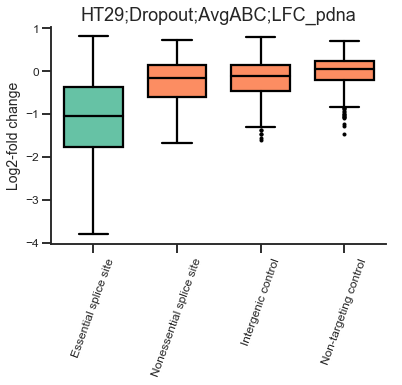

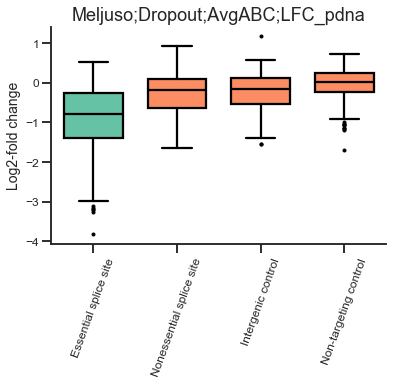

In [28]:
#BE3
filtered_ht29 = process_data(filename='Supplementary_Table10_ClinVar_v3.xlsx',sheet='BE3_HT29',
                        conditions_list=[['HT29','Cisplatin',['A','B','C']],
                                         ['HT29','Hygromycin',['A','B','C']]],
                        annot_sheet='Library annotation',tiling=False)

filtered_meljuso = process_data(filename='Supplementary_Table10_ClinVar_v3.xlsx',sheet='BE3_Meljuso',
                        conditions_list=[['Meljuso','Cisplatin',['A','B','C']],
                                         ['Meljuso','Hygromycin',['A','B','C']]],
                        annot_sheet='Library annotation',tiling=False)

filtered = pd.merge(filtered_ht29,filtered_meljuso,on='Construct Barcode')

# Merge replicates
for cell_line in ['HT29','Meljuso']:
    filtered.loc[:,cell_line+';Dropout;AvgABC;LFC_pdna'] = filtered.loc[:,[cell_line+';Dropout;RepA;LFC_pdna',
                                                                     cell_line+';Dropout;RepB;LFC_pdna',
                                                                     cell_line+';Dropout;RepC;LFC_pdna']].mean(axis=1)
    filtered.loc[:,cell_line+';Cisplatin;AvgABC;LFC_dropout'] = filtered.loc[:,[cell_line+';Cisplatin;RepA;LFC_dropout',
                                                                          cell_line+';Cisplatin;RepB;LFC_dropout',
                                                                          cell_line+';Cisplatin;RepC;LFC_dropout']].mean(axis=1)
    filtered.loc[:,cell_line+';Hygromycin;AvgABC;LFC_dropout'] = filtered.loc[:,[cell_line+';Hygromycin;RepA;LFC_dropout',
                                                                          cell_line+';Hygromycin;RepB;LFC_dropout',
                                                                          cell_line+';Hygromycin;RepC;LFC_dropout']].mean(axis=1)

cols = ['HT29;Dropout;AvgABC;LFC_pdna','HT29;Cisplatin;AvgABC;LFC_dropout','HT29;Hygromycin;AvgABC;LFC_dropout',
        'Meljuso;Dropout;AvgABC;LFC_pdna','Meljuso;Cisplatin;AvgABC;LFC_dropout','Meljuso;Hygromycin;AvgABC;LFC_dropout']

# Get z-scored LFC relative to specified control genes
for col in cols:                                                                           
    filtered = be.get_z_score_v3(filtered,col,'Type_x',['Intergenic control'])

# Write to file
filtered.to_csv('../Data/Filtered_LFC_files/Table_S10_filtered_BE3_v1.csv',index=False)    

# Generate boxplots to show distribution of negative and positive control sgRNAs
dropout_cols = [x for x in list(filtered.columns) if ('Dropout' in x)&('AvgABC' in x)&('z-score' not in x)]
ctrls = ['Essential splice site','Nonessential splice site','Intergenic control','Non-targeting control']
ctrl_df = filtered[filtered['Type_x'].isin(ctrls)]
for i,c in enumerate(dropout_cols):
    outputname = c+'_controls_boxplot' 
    generate_qc_boxplot(ctrl_df,c,ctrls,'Type_x',outputname)

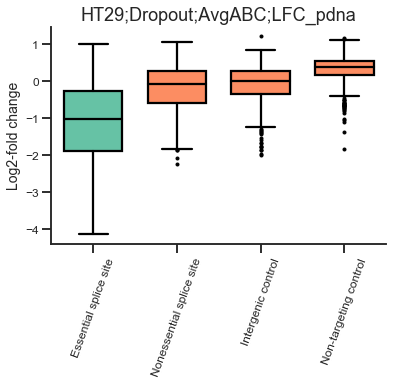

In [10]:
#wtCas9
filtered = process_data(filename='Supplementary_Table10_ClinVar_v3.xlsx',sheet='wtCas9_HT29',
                        conditions_list=[['HT29','Cisplatin',['A','B','C']],
                                         ['HT29','Hygromycin',['A','B','C']]],
                        annot_sheet='Library annotation',tiling=False)

# Merge replicates
for cell_line in ['HT29']:
    filtered.loc[:,cell_line+';Dropout;AvgABC;LFC_pdna'] = filtered.loc[:,[cell_line+';Dropout;RepA;LFC_pdna',
                                                                     cell_line+';Dropout;RepB;LFC_pdna',
                                                                     cell_line+';Dropout;RepC;LFC_pdna']].mean(axis=1)
    filtered.loc[:,cell_line+';Cisplatin;AvgABC;LFC_dropout'] = filtered.loc[:,[cell_line+';Cisplatin;RepA;LFC_dropout',
                                                                          cell_line+';Cisplatin;RepB;LFC_dropout',
                                                                          cell_line+';Cisplatin;RepC;LFC_dropout']].mean(axis=1)
    filtered.loc[:,cell_line+';Hygromycin;AvgABC;LFC_dropout'] = filtered.loc[:,[cell_line+';Hygromycin;RepA;LFC_dropout',
                                                                          cell_line+';Hygromycin;RepB;LFC_dropout',
                                                                          cell_line+';Hygromycin;RepC;LFC_dropout']].mean(axis=1)

cols = ['HT29;Dropout;AvgABC;LFC_pdna','HT29;Cisplatin;AvgABC;LFC_dropout','HT29;Hygromycin;AvgABC;LFC_dropout']

# Get z-scored LFC relative to specified control genes
for col in cols:                                                                           
    filtered = be.get_z_score_v3(filtered,col,'Type',['Intergenic control'])

# Write to file
filtered.to_csv('../Data/Filtered_LFC_files/Table_S10_filtered_wtCas9_v1.csv',index=False)    

# Generate boxplots to show distribution of negative and positive control sgRNAs
dropout_cols = [x for x in list(filtered.columns) if ('Dropout' in x)&('AvgABC' in x)&('z-score' not in x)]
ctrls = ['Essential splice site','Nonessential splice site','Intergenic control','Non-targeting control']
ctrl_df = filtered[filtered['Type'].isin(ctrls)]
for i,c in enumerate(dropout_cols):
    outputname = c+'_controls_boxplot' 
    generate_qc_boxplot(ctrl_df,c,ctrls,'Type',outputname)